In [1]:
from functools import reduce
import datetime
from calendar import Calendar
import argparse

import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql.window import Window

# for notebook
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

pd.options.mode.chained_assignment = None
pd.set_option("display.max_columns", 100)

In [2]:
APP_NAME = "KF-ShopGrid-Jupyter"

# SET UP SPARK
# ----------------
run_mode = "python" 

if run_mode == "python":
    conf1 = pyspark.SparkConf().setAll([
        ("spark.app.name", APP_NAME),
        ("spark.driver.memory","20g"),
        ("spark.master","yarn"),
        ("spark.executor.memory", "10g"),
        ("spark.executor.instances", 5),
        ("spark.executor.cores", "5"),
        ('spark.sql.crossJoin.enabled', True),
        ('spark.sql.shuffle.partitions', 8) 
        ])
    spark = SparkSession.builder.config(conf = conf1).getOrCreate()
elif run_mode == "spark-submit":
    spark = SparkSession.builder.appName(APP_NAME).getOrCreate()
else:
    pass

spark.sparkContext.applicationId

'application_1658797823938_3284'

This contains data from 08/23 - 09/12. (TODO: derive this from HDFS, not manually)

Would need to loop over folders in `input_dir` to associate search date with counts. For now, analyze en masse

In [6]:
input_dir = "/user/kendra.frederick/lookups/top_markets/daily_counts/"

In [18]:
# num_shop_days = (datetime.date(2022,9,12) - datetime.date(2022,8,23)).days + 1

In [4]:
!hdfs dfs -ls $input_dir

Found 21 items
drwxr-xr-x   - kendra.frederick hdfs          0 2022-09-13 23:00 /user/kendra.frederick/lookups/top_markets/daily_counts/20220823
drwxr-xr-x   - kendra.frederick hdfs          0 2022-09-13 23:06 /user/kendra.frederick/lookups/top_markets/daily_counts/20220824
drwxr-xr-x   - kendra.frederick hdfs          0 2022-09-13 23:18 /user/kendra.frederick/lookups/top_markets/daily_counts/20220825
drwxr-xr-x   - kendra.frederick hdfs          0 2022-09-13 23:31 /user/kendra.frederick/lookups/top_markets/daily_counts/20220826
drwxr-xr-x   - kendra.frederick hdfs          0 2022-09-13 23:41 /user/kendra.frederick/lookups/top_markets/daily_counts/20220827
drwxr-xr-x   - kendra.frederick hdfs          0 2022-09-13 23:58 /user/kendra.frederick/lookups/top_markets/daily_counts/20220828
drwxr-xr-x   - kendra.frederick hdfs          0 2022-09-14 00:15 /user/kendra.frederick/lookups/top_markets/daily_counts/20220829
drwxr-xr-x   - kendra.frederick hdfs          0 2022-09-14 00:24 /user/kend

In [7]:
x = !hdfs dfs -ls $input_dir | wc -l

num_shop_days = int(x[0]) - 1
num_shop_days

21

In [8]:
df = spark.read.csv(input_dir + "*/", header=True)

In [8]:
df.show(5)

+----------------+---------------------+-------------+---------+-------------+------------------+-------+
|outOriginAirport|outDestinationAirport|num_solutions|num_shops|originDecoded|destinationDecoded| market|
+----------------+---------------------+-------------+---------+-------------+------------------+-------+
|        67962112|            152245248|     33854333|  1011554|          DME|               IST|DME-IST|
|       369823488|            152245248|    210593372|   878505|          VKO|               IST|VKO-IST|
|       151195136|             34278144|     99113222|   805407|          ICN|               BKK|ICN-BKK|
|       201855488|             34278144|     61012154|   800055|          LHR|               BKK|LHR-BKK|
|       369823488|            318838528|    102045517|   765894|          VKO|               SAW|VKO-SAW|
+----------------+---------------------+-------------+---------+-------------+------------------+-------+
only showing top 5 rows



In [9]:
df.count()

15263362

# one approach

In [ ]:
market_cnts = df.groupBy("market").agg(F.sum('num_shops').alias("sum_shop_counts"))
market_cnts = market_cnts.withColumn("avg_counts_per_day", F.col("sum_shop_counts") / num_shop_days)

In [11]:
market_cnts.count()

1380419

In [43]:
col = "avg_counts_per_day"
w = Window.orderBy(col)

output = (market_cnts
          .withColumn("cume_proba", F.percent_rank())
          .withColumn(col, F.round(F.col(col), 0))
          .groupBy(col)
          .agg(
              F.max("cume_proba").alias("cume_proba"),
              F.count('*').alias("data_count")
          )
          .withColumn("cume_proba", F.lead(F.col("cume_proba")).over(w))
          .fillna(1, subset=["cume_proba"])
         )

In [44]:
output.show(5)

Py4JJavaError: An error occurred while calling o303.showString.
: org.apache.spark.sql.catalyst.errors.package$TreeNodeException: execute, tree:
Exchange SinglePartition
+- *HashAggregate(keys=[avg_counts_per_day#317], functions=[count(1), max(cume_proba#311)], output=[avg_counts_per_day#317, data_count#332L, cume_proba#329])
   +- Exchange hashpartitioning(avg_counts_per_day#317, 8)
      +- *HashAggregate(keys=[avg_counts_per_day#317], functions=[partial_count(1), partial_max(cume_proba#311)], output=[avg_counts_per_day#317, count#358L, max#359])
         +- *HashAggregate(keys=[market#6], functions=[sum(cast(num_shops#3 as double))], output=[avg_counts_per_day#317, cume_proba#311])
            +- Exchange hashpartitioning(market#6, 8)
               +- *HashAggregate(keys=[market#6], functions=[partial_sum(cast(num_shops#3 as double))], output=[market#6, sum#361])
                  +- *FileScan csv [num_shops#3,market#6] Batched: false, Format: CSV, Location: InMemoryFileIndex[hdfs://ngsearchdev/user/kendra.frederick/lookups/top_markets/daily_counts/20220..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<num_shops:string,market:string>

	at org.apache.spark.sql.catalyst.errors.package$.attachTree(package.scala:56)
	at org.apache.spark.sql.execution.exchange.ShuffleExchange.doExecute(ShuffleExchange.scala:112)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:135)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:132)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:113)
	at org.apache.spark.sql.execution.InputAdapter.inputRDDs(WholeStageCodegenExec.scala:235)
	at org.apache.spark.sql.execution.SortExec.inputRDDs(SortExec.scala:121)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:368)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:135)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:132)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:113)
	at org.apache.spark.sql.execution.window.WindowExec.doExecute(WindowExec.scala:289)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:135)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:132)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:113)
	at org.apache.spark.sql.execution.InputAdapter.inputRDDs(WholeStageCodegenExec.scala:235)
	at org.apache.spark.sql.execution.ProjectExec.inputRDDs(basicPhysicalOperators.scala:42)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:368)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:135)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:132)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:113)
	at org.apache.spark.sql.execution.SparkPlan.getByteArrayRdd(SparkPlan.scala:225)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:308)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset$$anonfun$org$apache$spark$sql$Dataset$$execute$1$1.apply(Dataset.scala:2378)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:57)
	at org.apache.spark.sql.Dataset.withNewExecutionId(Dataset.scala:2780)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$execute$1(Dataset.scala:2377)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collect(Dataset.scala:2384)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2120)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2119)
	at org.apache.spark.sql.Dataset.withTypedCallback(Dataset.scala:2810)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2119)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2334)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:248)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.sql.catalyst.errors.package$TreeNodeException: execute, tree:
Exchange hashpartitioning(avg_counts_per_day#317, 8)
+- *HashAggregate(keys=[avg_counts_per_day#317], functions=[partial_count(1), partial_max(cume_proba#311)], output=[avg_counts_per_day#317, count#358L, max#359])
   +- *HashAggregate(keys=[market#6], functions=[sum(cast(num_shops#3 as double))], output=[avg_counts_per_day#317, cume_proba#311])
      +- Exchange hashpartitioning(market#6, 8)
         +- *HashAggregate(keys=[market#6], functions=[partial_sum(cast(num_shops#3 as double))], output=[market#6, sum#361])
            +- *FileScan csv [num_shops#3,market#6] Batched: false, Format: CSV, Location: InMemoryFileIndex[hdfs://ngsearchdev/user/kendra.frederick/lookups/top_markets/daily_counts/20220..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<num_shops:string,market:string>

	at org.apache.spark.sql.catalyst.errors.package$.attachTree(package.scala:56)
	at org.apache.spark.sql.execution.exchange.ShuffleExchange.doExecute(ShuffleExchange.scala:112)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:135)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:132)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:113)
	at org.apache.spark.sql.execution.InputAdapter.inputRDDs(WholeStageCodegenExec.scala:235)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.inputRDDs(HashAggregateExec.scala:141)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:368)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:135)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:132)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:113)
	at org.apache.spark.sql.execution.exchange.ShuffleExchange.prepareShuffleDependency(ShuffleExchange.scala:85)
	at org.apache.spark.sql.execution.exchange.ShuffleExchange$$anonfun$doExecute$1.apply(ShuffleExchange.scala:121)
	at org.apache.spark.sql.execution.exchange.ShuffleExchange$$anonfun$doExecute$1.apply(ShuffleExchange.scala:112)
	at org.apache.spark.sql.catalyst.errors.package$.attachTree(package.scala:52)
	... 57 more
Caused by: java.lang.UnsupportedOperationException: Cannot evaluate expression: percent_rank()
	at org.apache.spark.sql.catalyst.expressions.Unevaluable$class.doGenCode(Expression.scala:224)
	at org.apache.spark.sql.catalyst.expressions.aggregate.DeclarativeAggregate.doGenCode(interfaces.scala:342)
	at org.apache.spark.sql.catalyst.expressions.Expression$$anonfun$genCode$2.apply(Expression.scala:104)
	at org.apache.spark.sql.catalyst.expressions.Expression$$anonfun$genCode$2.apply(Expression.scala:101)
	at scala.Option.getOrElse(Option.scala:121)
	at org.apache.spark.sql.catalyst.expressions.Expression.genCode(Expression.scala:101)
	at org.apache.spark.sql.catalyst.expressions.Alias.genCode(namedExpressions.scala:147)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec$$anonfun$32.apply(HashAggregateExec.scala:448)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec$$anonfun$32.apply(HashAggregateExec.scala:447)
	at scala.collection.TraversableLike$$anonfun$map$1.apply(TraversableLike.scala:234)
	at scala.collection.TraversableLike$$anonfun$map$1.apply(TraversableLike.scala:234)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at scala.collection.TraversableLike$class.map(TraversableLike.scala:234)
	at scala.collection.AbstractTraversable.map(Traversable.scala:104)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.generateResultCode(HashAggregateExec.scala:447)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.doProduceWithKeys(HashAggregateExec.scala:610)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.doProduce(HashAggregateExec.scala:148)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:83)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:78)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:135)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:132)
	at org.apache.spark.sql.execution.CodegenSupport$class.produce(WholeStageCodegenExec.scala:78)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.produce(HashAggregateExec.scala:38)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.doProduceWithKeys(HashAggregateExec.scala:598)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.doProduce(HashAggregateExec.scala:148)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:83)
	at org.apache.spark.sql.execution.CodegenSupport$$anonfun$produce$1.apply(WholeStageCodegenExec.scala:78)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:135)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:132)
	at org.apache.spark.sql.execution.CodegenSupport$class.produce(WholeStageCodegenExec.scala:78)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.produce(HashAggregateExec.scala:38)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doCodeGen(WholeStageCodegenExec.scala:313)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:354)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:135)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:132)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:113)
	at org.apache.spark.sql.execution.exchange.ShuffleExchange.prepareShuffleDependency(ShuffleExchange.scala:85)
	at org.apache.spark.sql.execution.exchange.ShuffleExchange$$anonfun$doExecute$1.apply(ShuffleExchange.scala:121)
	at org.apache.spark.sql.execution.exchange.ShuffleExchange$$anonfun$doExecute$1.apply(ShuffleExchange.scala:112)
	at org.apache.spark.sql.catalyst.errors.package$.attachTree(package.scala:52)
	... 77 more


In [46]:
market_cnts.show(5)

+-------+---------------+------------------+
| market|sum_shop_counts|avg_counts_per_day|
+-------+---------------+------------------+
|LHR-BKK|     1.682557E7|  801217.619047619|
|LHR-DEL|    1.1248877E7| 535660.8095238095|
|LHR-DXB|    1.1130771E7| 530036.7142857143|
|LHR-IST|    1.0328931E7|491853.85714285716|
|DMK-CNX|      6784278.0|323060.85714285716|
+-------+---------------+------------------+
only showing top 5 rows



In [47]:
col

'avg_counts_per_day'

In [55]:
w = Window.orderBy("avg_counts_per_day")
w2 = Window.orderBy("rounded_log_counts")

output = (market_cnts
          .withColumn("cume_proba", F.percent_rank().over(w))
          .withColumn("log_avg_counts", F.log10(F.col(col)))
          .withColumn("rounded_log_counts", F.round(F.col("log_avg_counts"), 1))
          .groupBy("rounded_log_counts")
          .agg(
              F.max("cume_proba").alias("cume_proba"),
              F.count('*').alias("data_count")
          )
          .withColumn("cume_proba", F.lead(F.col("cume_proba")).over(w2))
          .fillna(1, subset=["cume_proba"])
          .withColumn("avg_counts", F.pow(F.col("rounded_log_counts"), F.lit(10)))
         )

In [56]:
output.show(5)

+------------------+-------------------+----------+--------------------+
|rounded_log_counts|         cume_proba|data_count|          avg_counts|
+------------------+-------------------+----------+--------------------+
|              -1.3|0.06902257142401794|     95280|  13.785849184900005|
|              -1.0| 0.1294636841884125|     83434|                 1.0|
|              -0.8|0.16946026493424454|     55212| 0.10737418240000006|
|              -0.7|0.20662871680896655|     51308|0.028247524899999984|
|              -0.6|0.26207496569879557|     39538|0.006046617599999997|
+------------------+-------------------+----------+--------------------+
only showing top 5 rows



In [57]:
output.orderBy(F.desc("cume_proba")).show()

+------------------+------------------+----------+--------------------+
|rounded_log_counts|        cume_proba|data_count|          avg_counts|
+------------------+------------------+----------+--------------------+
|               5.9|               1.0|         3| 5.111167533006417E7|
|               6.0|               1.0|         2|         6.0466176E7|
|               5.8|0.9999985511634881|         7| 4.308042068994057E7|
|               5.7|0.9999963779087204|         9| 3.620333314568914E7|
|               5.6| 0.999991306980929|        16|3.0330548909611396E7|
|               5.5|0.9999847872166256|        28|2.5329516211914062E7|
|               5.4| 0.999973196524531|        57|2.1083251926492073E7|
|               5.3|0.9999529128133652|        91|  1.74887470365513E7|
|               5.2|0.9999116209727779|       118|1.4455510594905708E7|
|               5.1|0.9998456989114891|       173|1.1904242382761292E7|
|               5.0|0.9997602175572906|       234|           976

In [58]:
pdf_cdf = output.toPandas()

In [59]:
pdf_cdf.sort_values(by="rounded_log_counts", inplace=True);

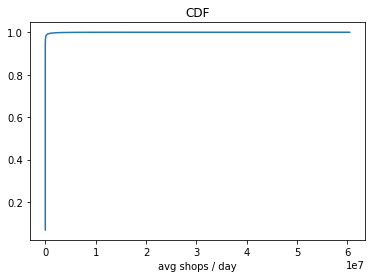

In [61]:
plt.plot(pdf_cdf['avg_counts'], pdf_cdf['cume_proba']);
plt.title("CDF by volume")
plt.xlabel("avg shops / day");

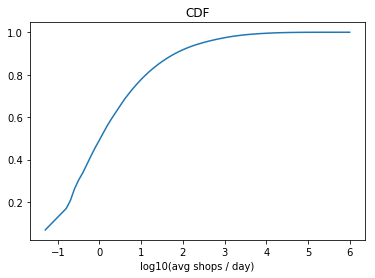

In [62]:
plt.plot(pdf_cdf['rounded_log_counts'], pdf_cdf['cume_proba']);
plt.title("CDF")
plt.xlabel("log10(avg shops / day)");

In [64]:
len(pdf_cdf)

71

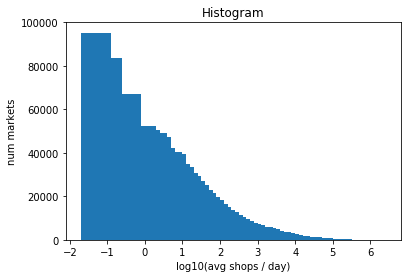

In [65]:
plt.bar(pdf_cdf['rounded_log_counts'], pdf_cdf['data_count']);
plt.title("Histogram")
plt.xlabel("log10(avg shops / day)");
plt.ylabel("num markets");

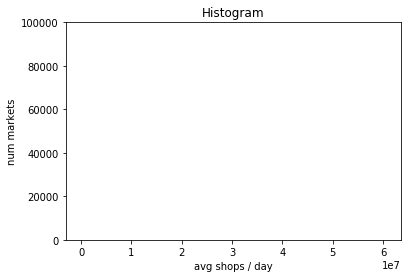

In [66]:
plt.bar(pdf_cdf['avg_counts'], pdf_cdf['data_count']);
plt.title("Histogram")
plt.xlabel("avg shops / day");
plt.ylabel("num markets");

# another take

In [9]:
market_cnts = df.groupBy("market").agg(F.sum('num_shops').alias("sum_shop_counts"))
market_cnts = market_cnts.withColumn("avg_counts_per_day", F.col("sum_shop_counts") / num_shop_days)

# w = Window.orderBy("avg_counts_per_day")

w = Window.partitionBy()

# market_cnts = market_cnts.withColumn("pct_rank", F.percent_rank().over(w))
# market_cnts = market_cnts.withColumn("cume_dist", F.cume_dist().over(w))

market_cnts = market_cnts.withColumn("pct_total_shops",
                                    F.col("sum_shop_counts") / F.sum("sum_shop_counts").over(w))

w2 = (Window
      .orderBy("avg_counts_per_day")
      .rowsBetween(Window.unboundedPreceding, Window.currentRow)
     )
market_cnts = market_cnts.withColumn("cume_pct",
                                    F.sum("pct_total_shops").over(w2))

w3 = (Window
      .orderBy(F.desc("avg_counts_per_day"))
      .rowsBetween(Window.unboundedPreceding, Window.currentRow)
     )
market_cnts = market_cnts.withColumn("rev_cume_pct",
                                    F.sum("pct_total_shops").over(w3))

w_ord = Window.orderBy(F.desc("sum_shop_counts"))
market_cnts = market_cnts.withColumn("rank", F.rank().over(w_ord))

In [12]:
market_cnts.count()

1380419

In [76]:
# market_cnts.orderBy(F.desc("sum_shop_counts")).show()

+-------+---------------+------------------+--------------------+------------------+
| market|sum_shop_counts|avg_counts_per_day|     pct_total_shops|          cume_pct|
+-------+---------------+------------------+--------------------+------------------+
|DME-IST|    1.9618962E7| 934236.2857142857|0.001922007205722...|1.0000000000000018|
|VKO-IST|    1.9499312E7| 928538.6666666666|0.001910285476399785|0.9980779927942788|
|VKO-SAW|    1.6988424E7| 808972.5714285715|0.001664301778140...| 0.996167707317879|
|LHR-BKK|     1.682557E7|  801217.619047619|0.001648347490575...|0.9945034055397382|
|ICN-BKK|    1.6449886E7| 783327.9047619047|0.001611542925936...|0.9928550580491627|
|SIN-BKK|    1.4635868E7| 696946.0952380953|0.001433829361513...|0.9912435151232261|
|SVO-IST|    1.4079205E7| 670438.3333333334|0.001379294860800...| 0.989809685761713|
|DME-SAW|    1.2833609E7| 611124.2380952381|0.001257267788858...| 0.988430390900912|
|BKK-ICN|    1.2599142E7| 599959.1428571428|0.001234297803825...|

In [14]:
pdf_out2 = market_cnts.toPandas()

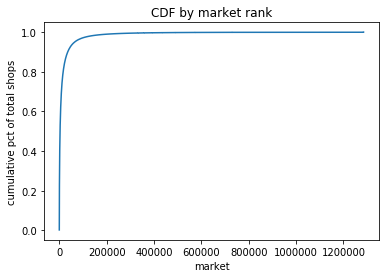

In [93]:
plt.plot(pdf_out2['rank'], pdf_out2['rev_cume_pct'])
plt.xlabel('market')
plt.ylabel("cumulative pct of total shops");
plt.title("CDF by market rank");

In [15]:
vol_pct = 0.8
rank = pdf_out2[pdf_out2['rev_cume_pct'] > vol_pct].head(1)['rank'].values[0]
rank_pct = rank / len(pdf_out2)
print(f"The top {rank_pct*100:.1f}% of markets account for {vol_pct*100:.0f}% of the shopping volume")

The top 1.2% of markets account for 80% of the shopping volume


In [16]:
vol_pct = 0.9
rank = pdf_out2[pdf_out2['rev_cume_pct'] > vol_pct].head(1)['rank'].values[0]
rank_pct = rank / len(pdf_out2)
print(f"The top {rank_pct*100:.1f}% of markets account for {vol_pct*100:.0f}% of the shopping volume")

The top 2.6% of markets account for 90% of the shopping volume


In [17]:
rank = 1000
vol_pct = pdf_out2[pdf_out2['rank'] == rank]['rev_cume_pct'].values[0]
print(f"The top {rank} markets account for {vol_pct*100:.0f}% of the shopping volume")

The top 1000 markets account for 30% of the shopping volume


I may need to expand my coverage data beyond the top 1000

Let's see how coverage looks up to the 1000th market first

In [27]:
vol_pct = 0.99
vol_pdf = pdf_out2[pdf_out2['rev_cume_pct'] > vol_pct]

print(f"There are {len(vol_pdf):,} markets (out of {len(pdf_out2):,} total) in the bottom {(1-vol_pct)*100:.1f}% of the shopping volume")

There are 1,182,762 markets (out of 1,380,419 total) in the bottom 1.0% of the shopping volume


In [26]:
pdf_out2.head()

,market,sum_shop_counts,avg_counts_per_day,pct_total_shops,cume_pct,rev_cume_pct,rank
0,DME-IST,19618962.0,934236.285714,0.001922,1.000000,0.001922,1
1,VKO-IST,19499312.0,928538.666667,0.001910,0.998078,0.003832,2
2,VKO-SAW,16988424.0,808972.571429,0.001664,0.996168,0.005497,3
3,LHR-BKK,16825570.0,801217.619048,0.001648,0.994503,0.007145,4
4,ICN-BKK,16449886.0,783327.904762,0.001612,0.992855,0.008756,5


In [9]:
spark.stop()